## Bert multi-label

In [220]:
!pip install transformers

In [221]:
import transformers
import torch
import pandas as pd
from tqdm.notebook import tqdm
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils import data
import numpy as np
from transformers import AdamW # optimizer
from transformers import get_linear_schedule_with_warmup # for learning rate
from transformers import BertModel

In [222]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [223]:
dataset = pd.read_csv("sample_data/new_label_dataset.csv")
testset = pd.read_csv("sample_data/new_label_testset.csv")

print(len(dataset))
print(len(testset))

29114
8179


In [224]:
dataset[:3]

Unnamed: 0  ... priority
0           0  ...      Low
1           1  ...      Low
2           2  ...      Low

[3 rows x 4 columns]

In [225]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

# convert str to list.
cat_tr_list = []
cat_te_list = []

for i in dataset['categories']:
    cat_tr_list.append(ast.literal_eval(i))
    
for i in testset['categories']:
    cat_te_list.append(ast.literal_eval(i))

mlb_tr = MultiLabelBinarizer()
labels_tr = mlb_tr.fit_transform(cat_tr_list)
mlb_te = MultiLabelBinarizer()
labels_te = mlb_te.fit_transform(cat_te_list)

categories_tr = mlb_tr.classes_
categories_te = mlb_te.classes_

print(labels_tr.shape)
print(labels_te.shape)

(29114, 25)
(8179, 25)


In [226]:
class GPRreviewDataset(data.Dataset):
    def __init__(self, content, target, tokenizer, max_len):
        self.content = content
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.content)
    
    def __getitem__(self, item):
        content = str(self.content[item])
        encoding = tokenizer.encode_plus(
            content,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': content,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.float)
        }

In [227]:
MAX_LEN = 30
BATCH_SIZE = 32

df_train, df_test = dataset, testset

In [228]:
def create_data_loader(df, labels, tokenizer, max_len, batch_size):
    ds = GPRreviewDataset(
        content = df.content.to_numpy(),
        target = labels,
        tokenizer = tokenizer,
        max_len = max_len,
    )
    return data.DataLoader(
        ds, 
        batch_size = batch_size,
    )

In [229]:
train_loader = create_data_loader(df_train, labels_tr, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(df_test, labels_te, tokenizer, MAX_LEN, BATCH_SIZE)

In [230]:
next(iter(train_loader))['targets'].shape

torch.Size([32, 25])

In [231]:
from transformers import BertForSequenceClassification

In [232]:
device = 'cuda'

In [233]:
class BertClassifier(nn.Module):
    def __init__(self, n_class):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_class)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        output = self.drop(pooled_output)
        output1 = self.out(output)
        return output1

In [234]:
model = BertClassifier(25).to(device)

In [235]:
# for imbalance dataset. reduction = 'none' in loss function.
weight = torch.tensor(labels_tr.sum(axis=0)/sum(labels_tr.sum(axis=0))).to(device)

weight

tensor([0.0213, 0.0016, 0.0224, 0.0324, 0.0110, 0.0178, 0.0798, 0.0559, 0.0019,
        0.0807, 0.0026, 0.0844, 0.0742, 0.0022, 0.1038, 0.0089, 0.1129, 0.0180,
        0.0316, 0.0032, 0.0994, 0.0169, 0.0811, 0.0019, 0.0338],
       device='cuda:0', dtype=torch.float64)

In [236]:
def train(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = 0
    correct_predictions = 0
    for d in data_loader:
        optimizer.zero_grad()
        
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        output = model(input_ids = input_ids, attention_mask = attention_mask)
        loss = loss_fn(output, targets)
        loss = (loss * weight).mean()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses+=loss.item()
    return losses*32/len(data_loader)

In [237]:
def val(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = 0
    preds_list, targets_list, prob_list = [], [], []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            output = model(input_ids = input_ids, attention_mask = attention_mask)
            loss = loss_fn(output, targets)
            loss = (loss * weight).mean()
            losses+=loss.item()

            preds = 1/(1 + np.exp(-output.cpu().numpy()))
            preds_list.extend(preds)

            targets_list.extend(targets.cpu().numpy())

    return losses*32/len(data_loader), preds_list, targets_list

In [238]:
EPOCHS = 30
train_loss_list, val_loss_list = [], []

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCEWithLogitsLoss(reduction='none').to(device) 

for epoch in tqdm(range(EPOCHS)):
    train_loss = train(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    val_loss, preds_list, targets_list = val(
        model,
        test_loader,
        loss_fn,
        device,
        len(df_test)
    )

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print("train loss: ", train_loss, "val loss:", val_loss)

train loss:  0.5335907218803123 val loss: 0.6052958592666067
train loss:  0.5430526223471498 val loss: 0.5874398947459752
train loss:  0.555466300249456 val loss: 0.6283879879682004
train loss:  0.5627616847061283 val loss: 0.6237336368419363
train loss:  0.5538016298012515 val loss: 0.5888230177415146
train loss:  0.558915893669623 val loss: 0.6015282828040523
train loss:  0.5689463767959855 val loss: 0.6087190594278643
train loss:  0.5753782994436477 val loss: 0.614235988215636
train loss:  0.5683067225668791 val loss: 0.6139137542652953
train loss:  0.5637181139775412 val loss: 0.5805477300627129
train loss:  0.567549701090886 val loss: 0.5982423058167727
train loss:  0.5647004069505871 val loss: 0.5989316823834291
train loss:  0.567789865968097 val loss: 0.589352054154694
train loss:  0.5744944406272668 val loss: 0.5965083712684038
train loss:  0.5810488564319731 val loss: 0.5952615934328727
train loss:  0.5847185514356524 val loss: 0.5989966992311001
train loss:  0.584194168553035

### Result:

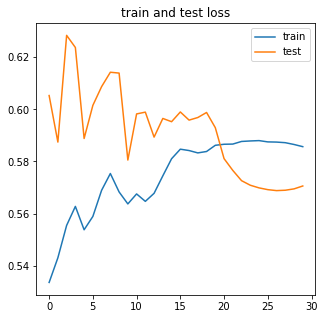

In [239]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([i for i in range(EPOCHS)], train_loss_list, label="train")
plt.plot([i for i in range(EPOCHS)], val_loss_list, label="test")
plt.title("train and test loss")
plt.legend()

In [240]:
preds_te_arr = np.array(preds_list).reshape((-1, 25))

preds_te_arr[preds_te_arr >= 0.5] = 1
preds_te_arr[preds_te_arr < 0.5] = 0

te_y = np.array(targets_list).reshape((-1, 25))


In [241]:
from sklearn.metrics import accuracy_score, f1_score

score = 0
acc = 0

for i in range(preds_te_arr.shape[1]):
    score += f1_score(te_y[:, i], preds_te_arr[:, i],average='macro')
    acc += accuracy_score(te_y[:, i], preds_te_arr[:, i])
    
print("Macro-average F1-score: ", score/25)
print("Average accuracy: ", acc/25)

Macro-average F1-score:  0.47235981051999265
Average accuracy:  0.9036605942046704
